In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
pip install --user "numpy<2.0"

Note: you may need to restart the kernel to use updated packages.


In [3]:
I = pd.read_csv("/home/jtempel/RU/Regression/I.csv")
Y1 = pd.read_csv("/home/jtempel/RU/Regression/Y1.csv")
Y2 = pd.read_csv("/home/jtempel/RU/Regression/Y2.csv")
Ifuture = pd.read_csv("/home/jtempel/RU/Regression/Ifuture.csv")

In [4]:
#create two data frames
Y_combined = pd.concat([Y1, Y2], axis = 1).to_numpy()
X_arr = pd.concat([Y1, Y2, I], axis = 1).to_numpy()

## Question (a)

In [5]:
#(a)
steps_back = 4
m = X_arr.shape[0]

#X data should be (1200-4) x 12
X_data = np.zeros((m - steps_back, steps_back*3))

#we make the X matrix with entries: Y1, Y2, I of the previous four time steps
for i in range(steps_back, m):
    X_data[i-steps_back] = X_arr[i-steps_back: i].flatten()
    #so the oldest time step is the first , i.e. 
    #X_data[t] = Y(t-4), I(t-4), Y(t-3), I(t-3), Y(t-2), I(t-2), Y(t-1), I(t-1)

Y_data = Y_combined[steps_back:]

In [6]:
train_size = 1000 - steps_back

#split the data and targets up in training and test data
X_train = X_data[:train_size]   # first 996 rows
Y_train = Y_data[:train_size]

X_test = X_data[train_size:]  # next 200 rows
Y_test = Y_data[train_size:]

#preprocessing the data 
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
Y_mean = np.mean(Y_train, axis=0)
Y_std = np.std(Y_train, axis=0)

X_train_n = (X_train - X_mean) / X_std
X_test_n = (X_test - X_mean) / X_std
Y_train_n = (Y_train - Y_mean) / Y_std
Y_test_n = (Y_test - Y_mean) / Y_std

In [73]:
#Since we do not want to have to run this code every time, we wrap it in a function

n_dim = len(X_train[0])

def modelmaker(n_dim):
    inputs = Input(shape=(n_dim,))
    x = Dense(20, activation='relu')(inputs) 
    x = Dense(20, activation='relu')(x)
    x = Dense(20, activation='relu')(x)
    x = Dense(20, activation='relu')(x)
    outputs = Dense(2, activation='linear')(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile
    model.compile(optimizer='adam', loss='mse')  
    return model

model = modelmaker(n_dim)
# Get a summary of the model, check if everything is OK
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 20)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,562 (6.10 KB)

 Trainable params: 1,562 (6.10 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
#for the non-normalized Y data
model = modelmaker(n_dim)
model.fit(X_train_n, Y_train, epochs=100, batch_size=50, verbose=0)

#predict on test data
predictions = model.predict(X_test_n, verbose=0)
MSE_Y1 = np.mean((predictions[:,0] - Y_test[:,0])**2)
MSE_Y2 = np.mean((predictions[:,1] - Y_test[:,1])**2)

print((round(MSE_Y1, 2), round(MSE_Y2, 2)) )

(26.38, 581.4)


In [9]:
#for the normalized Y data
model = modelmaker(n_dim)
model.fit(X_train_n, Y_train_n, epochs=100, batch_size=50, verbose=0)

#predict on test data
predictions_norm = model.predict(X_test_n, verbose=0)

#Scaling back
scaled_back_pred = predictions_norm * Y_std + Y_mean
MSE_Y1_scaled_back = np.mean((scaled_back_pred[:,0] - Y_test[:,0])**2)
MSE_Y2_scaled_back = np.mean((scaled_back_pred[:,1] - Y_test[:,1])**2)

print((round(MSE_Y1_scaled_back, 2), round(MSE_Y2_scaled_back, 2)))

(5.65, 683.35)


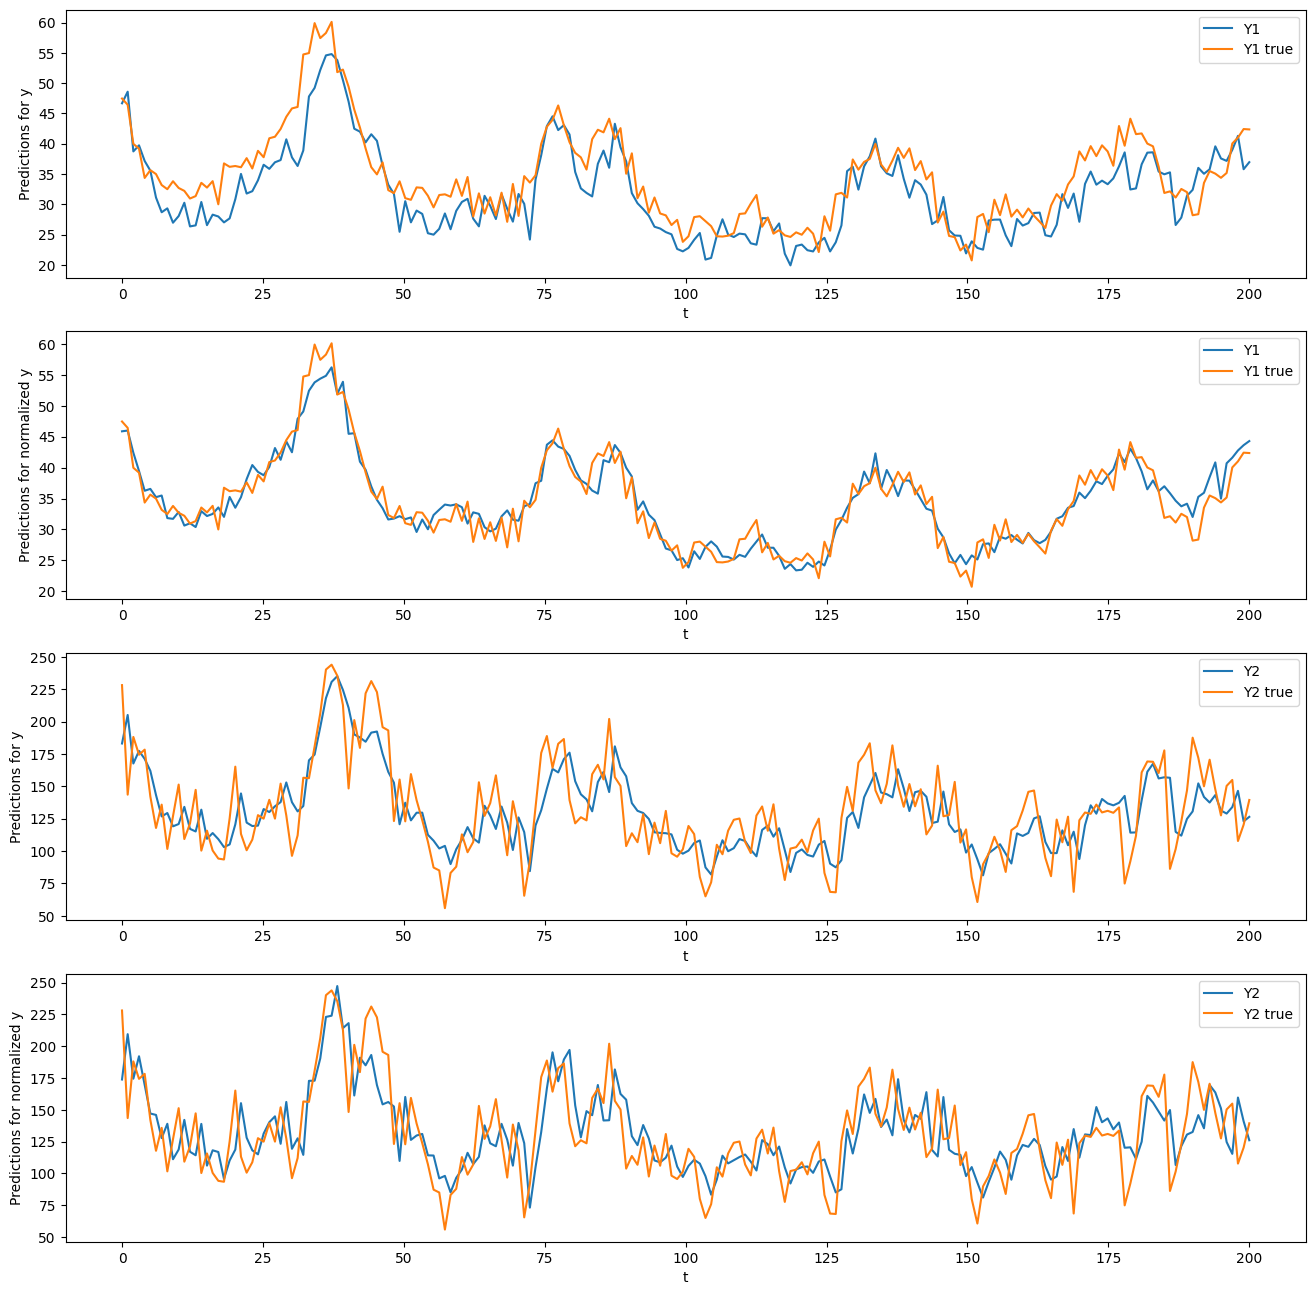

In [10]:
#for fun, we can plot them

times = np.linspace(0, 200, 200)

fig, axes = plt.subplots(4, 1, figsize = (16,16)) 

axes[0].plot(times, predictions[:,0], label = 'Y1')
axes[0].plot(times, Y_test[:,0], label = 'Y1 true')
axes[0].set_xlabel('t')
axes[0].set_ylabel('Predictions for y')
axes[0].legend()

axes[2].plot(times, predictions[:,1], label = 'Y2')
axes[2].plot(times, Y_test[:,1], label = 'Y2 true')
axes[2].set_ylabel('Predictions for y')
axes[2].set_xlabel('t')
axes[2].legend()

axes[1].plot(times, scaled_back_pred[:,0], label = 'Y1')
axes[1].plot(times, Y_test[:,0], label = 'Y1 true')
axes[1].set_xlabel('t')
axes[1].set_ylabel('Predictions for normalized y')
axes[1].legend()

axes[3].plot(times, scaled_back_pred[:,1], label = 'Y2')
axes[3].plot(times, Y_test[:,1], label = 'Y2 true')
axes[3].set_ylabel('Predictions for normalized y')
axes[3].set_xlabel('t')
axes[3].legend()

plt.show()

## Question (b)

In [11]:
# (b)

#We make a data set for Y(t)-Y(t-1), t= 4, 5, ...

Y_b = Y_combined[1:] - Y_combined[:-1] #Y_b = (Y(1)-Y(0), Y(2)-Y(1), ...)
Y_b_data = Y_b[3:]    #Y_b_data is a vector with (Y(4)-Y(3), Y(5)-Y(4), ...)

Y_b_train = Y_b_data[:996] 
Y_b_test = Y_b_data[996:]

#we use the same data for x as before
model = modelmaker(n_dim)
model.fit(X_train_n, Y_b_train, epochs=100, batch_size=50, verbose=0)

In [75]:
predictions_b = model.predict(X_test_n, verbose=0)

#scale the predictions back
#our first prediction (which is on the test data) is of (Y[1000]-Y[999]) so we use the initial value Y[999]
Y_back = np.zeros((len(predictions_b), 2))

for i in range(len(predictions_b)):
    Y_back[i] = Y_combined[999+i] + predictions_b[i]

#Calculate MSE's
MSE_Y1_b = np.mean((Y_back[:,0] - Y_test[:,0])**2)
MSE_Y2_b = np.mean((Y_back[:,1] - Y_test[:,1])**2)

print((round(MSE_Y1_b, 2), round(MSE_Y2_b, 2)))

(8.83, 769.8)


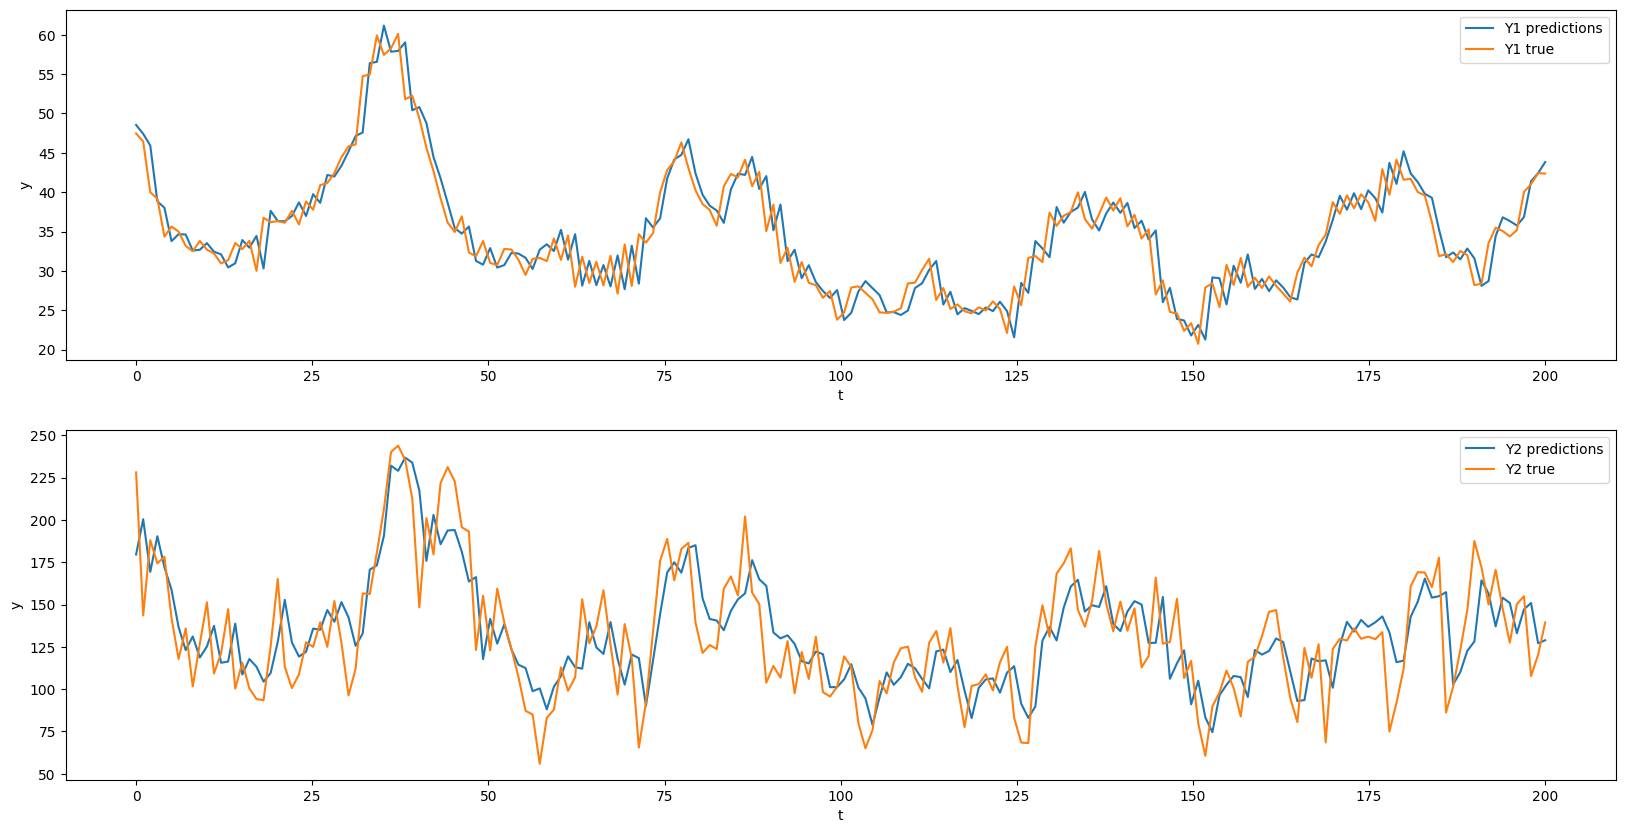

In [13]:
#plot it:
fig, axes = plt.subplots(2,1,figsize = (20,10))
axes[0].plot(times, Y_back[:,0], label = 'Y1 predictions')
axes[0].plot(times, Y_test[:,0], label = 'Y1 true')
axes[0].set_xlabel('t')
axes[0].set_ylabel('y')
axes[0].legend()

axes[1].plot(times, Y_back[:,1], label = 'Y2 predictions')
axes[1].plot(times, Y_test[:,1], label = 'Y2 true')
axes[1].set_xlabel('t')
axes[1].set_ylabel('y')
axes[1].legend()

plt.show()

## Question (b) for normalized increments

In [76]:
#We also try for normalized Y_b

Y_b_mean = np.mean(Y_b_train, axis=0)
Y_b_std = np.std(Y_b_train, axis=0)

Y_b_train_n = (Y_b_train - Y_b_mean) / Y_b_std
Y_b_test_n = (Y_b_test - Y_b_mean) / Y_b_std

model = modelmaker(n_dim)
model.fit(X_train_n, Y_b_train_n, epochs=100, batch_size=50, verbose=0)
predictions_b_n = model.predict(X_test_n, verbose=0)

In [77]:
#scale the predictions of the increments back 
pred_b  = predictions_b_n * Y_b_std + Y_b_mean   #the real increments

norm_Y_back = np.zeros((len(predictions_b_n), 2))

for i in range(len(predictions_b_n)):
    norm_Y_back[i] = Y_combined[999+i] + pred_b[i]

#Calculate the MSE's
norm_MSE_Y1_b = np.mean((norm_Y_back[:,0] - Y_test[:,0])**2)
norm_MSE_Y2_b = np.mean((norm_Y_back[:,1] - Y_test[:,1])**2)

print((round(norm_MSE_Y1_b, 2),round(norm_MSE_Y2_b, 2)) )
#In the next exercises we use the first model, since it balances out the MSE's a bit 
#more between Y1 and Y2. 

#the error of Y2 got worse. 

(5.25, 603.87)


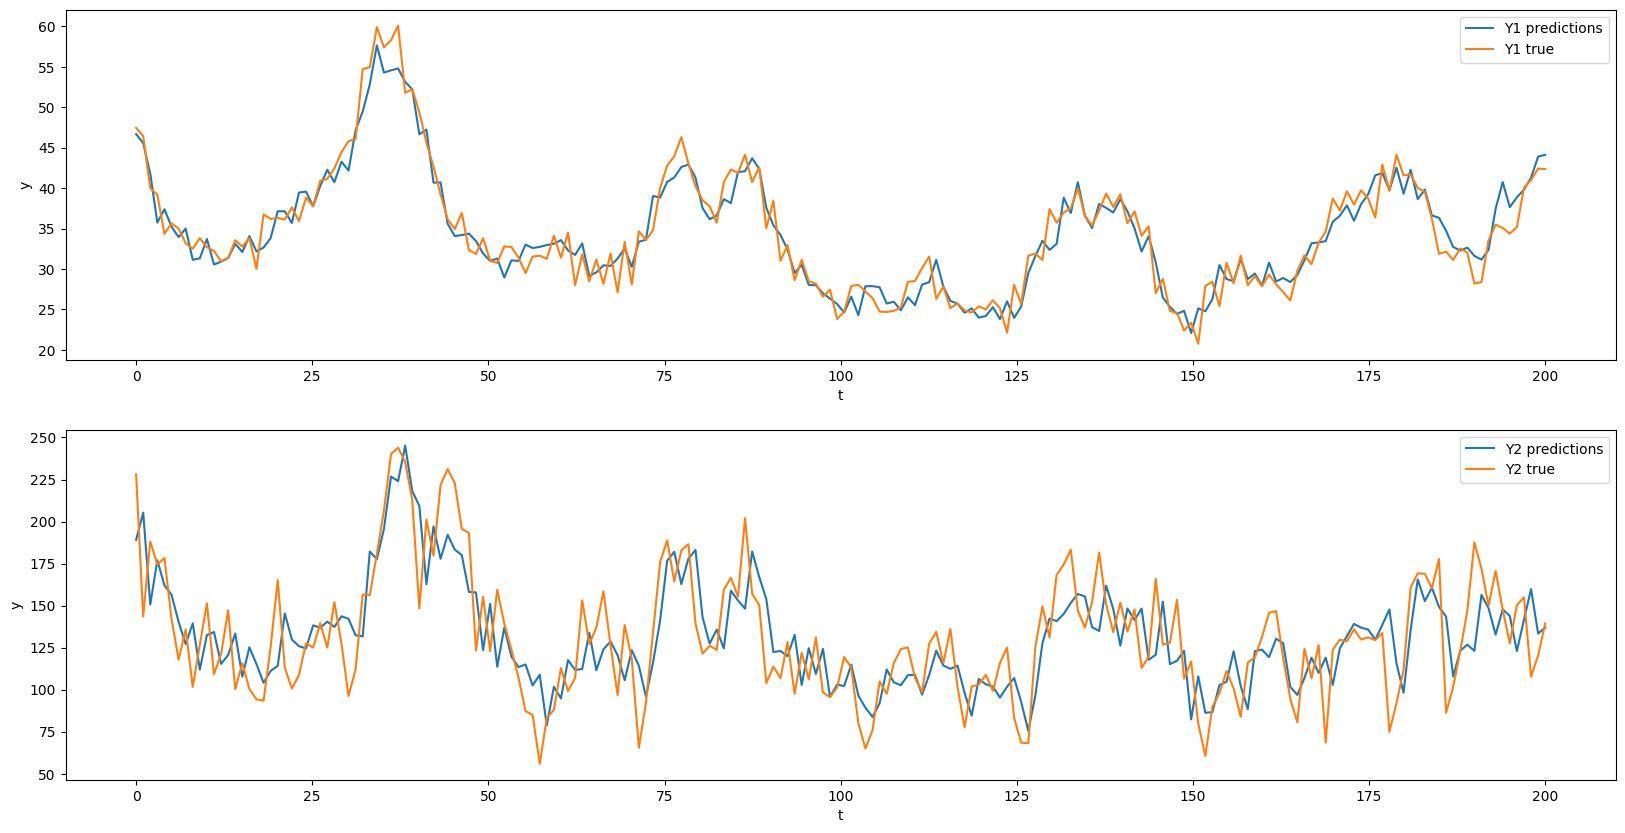

In [16]:
#plot them
fig, axes = plt.subplots(2,1,figsize = (20,10))
axes[0].plot(times, norm_Y_back[:,0], label = 'Y1 predictions')
axes[0].plot(times, Y_test[:,0], label = 'Y1 true')
axes[0].set_xlabel('t')
axes[0].set_ylabel('y')
axes[0].legend()

axes[1].plot(times, norm_Y_back[:,1], label = 'Y2 predictions')
axes[1].plot(times, Y_test[:,1], label = 'Y2 true')
axes[1].set_xlabel('t')
axes[1].set_ylabel('y')
axes[1].legend()

plt.show()

## Question (c)
Two ideas:
1. Leave $I$ out and look at MSE on test set
2. Look at 12 numerical derivatives 


In [17]:
#1.
#For the non-normalized targets:

#select the indices of the Y1 and Y2 columns (and not the I columns)
cols = [0, 1, 3, 4, 6, 7, 9, 10]

#select data with only those columns
X_train_c = X_train[:, cols]
X_test_c = X_test[:, cols]

#normalize this data:
X_mean_c = np.mean(X_train_c, axis=0)
X_std_c = np.std(X_train_c, axis=0)

X_train_n_c = (X_train_c - X_mean_c) / X_std_c
X_test_n_c = (X_test_c - X_mean_c) / X_std_c

n_dim_c = len(X_train_c[0])

#make the model and predict on the test set
model = modelmaker(n_dim_c)
model.fit(X_train_n_c, Y_train, epochs=100, batch_size=50, verbose=0)
predictions_c = model.predict(X_test_n_c)

MSE_Y1_c = np.mean((predictions_c[:,0] - Y_test[:,0])**2)
MSE_Y2_c = np.mean((predictions_c[:,1] - Y_test[:,1])**2)
print(round(MSE_Y1_c, 2), round(MSE_Y2_c, 2))


#For the normalized targets
model = modelmaker(n_dim_c)
model.fit(X_train_n_c, Y_train_n, epochs=100, batch_size=50, verbose=0)
predictions_n_c = model.predict(X_test_n_c)

#scale back
scaled_back_pred_c = predictions_n_c *  Y_std + Y_mean

MSE_Y1_n_c = np.mean((scaled_back_pred_c[:,0] - Y_test[:,0])**2)
MSE_Y2_n_c = np.mean((scaled_back_pred_c[:,1] - Y_test[:,1])**2)
print(round(MSE_Y1_n_c, 2), round(MSE_Y2_n_c, 2))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
25.29 559.57
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8.5 630.7


In [18]:
#2.

model = modelmaker(n_dim)
model.fit(X_train_n, Y_train_n, epochs=100, batch_size=50, verbose=0)
predictions_c = model.predict(X_test_n)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [19]:
Importance = np.zeros((12, 2))

for i in range(12):
    test_data_imp = X_test_n.copy()
    test_data_imp[:,i] = test_data_imp[:,i] + 0.1

    predictions_imp = model.predict(test_data_imp, verbose = 0)
    
    Importance[i] = 10*np.mean(predictions_imp - predictions_c, axis = 0)

names = ['Y1(t-4)', 'Y2(t-4)', 'I(t-4)', 'Y1(t-3)', 'Y2(t-3)', 'I(t-3)', 'Y1(t-2)', 'Y2(t-2)', 'I(t-2)','Y1(t-1)', 'Y2(t-1)', 'I(t-1)']
for i in range(12):
    print(names[i], '&', round(Importance[i,0], 3), '&', round(Importance[i,1], 3), '\\\ ')

#I(t-1) has a relatively large estimated derivative

Y1(t-4) & 0.212 & 0.068 \\ 
Y2(t-4) & 0.022 & 0.036 \\ 
I(t-4) & 0.004 & -0.061 \\ 
Y1(t-3) & 0.039 & 0.073 \\ 
Y2(t-3) & 0.012 & -0.11 \\ 
I(t-3) & 0.049 & 0.07 \\ 
Y1(t-2) & 0.308 & 0.181 \\ 
Y2(t-2) & -0.032 & 0.027 \\ 
I(t-2) & 0.012 & 0.007 \\ 
Y1(t-1) & 0.224 & 0.128 \\ 
Y2(t-1) & 0.024 & 0.511 \\ 
I(t-1) & 0.196 & -0.01 \\ 


## Question (c) numerical derivatives for non-normalized

In [20]:
#(c), 2, but for non normalized
model = modelmaker(n_dim)
model.fit(X_train_n, Y_train, epochs=100, batch_size=50, verbose=0)
predictions_c = model.predict(X_test_n)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [21]:
Importance = np.zeros((12, 2))

for i in range(12):
    test_data_imp = X_test_n.copy()
    test_data_imp[:,i] = test_data_imp[:,i] + 0.1

    predictions_imp = model.predict(test_data_imp, verbose = 0)
    Importance[i] = 10*np.mean(predictions_imp - predictions_c, axis = 0)

names = ['Y1(t-4)', 'Y2(t-4)', 'I(t-4)', 'Y1(t-3)', 'Y2(t-3)', 'I(t-3)', 'Y1(t-2)', 'Y2(t-2)', 'I(t-2)','Y1(t-1)', 'Y2(t-1)', 'I(t-1)']
for i in range(12):
    print(names[i], '&', round(Importance[i,0], 2), '&', round(Importance[i,1], 2), '\\\ ')

#I(t-3) has a relatively large estimated derivative

Y1(t-4) & 4.04 & 17.14 \\ 
Y2(t-4) & 0.05 & 0.45 \\ 
I(t-4) & -0.77 & -3.65 \\ 
Y1(t-3) & 3.13 & 14.45 \\ 
Y2(t-3) & -1.41 & -6.25 \\ 
I(t-3) & 1.98 & 8.18 \\ 
Y1(t-2) & 0.1 & 0.34 \\ 
Y2(t-2) & 0.32 & 1.81 \\ 
I(t-2) & 0.73 & 2.9 \\ 
Y1(t-1) & 1.28 & 5.5 \\ 
Y2(t-1) & 8.9 & 36.99 \\ 
I(t-1) & -0.33 & -2.85 \\ 


## Question (d)

In [23]:
#estimate the covariance matrix

#use the model from (a)
model = modelmaker(n_dim)
model.fit(X_train_n, Y_train, epochs=100, batch_size=50, verbose=0)

#predictions
train_pred = model.predict(X_train_n)
test_pred = model.predict(X_test_n)

#residuals
Y_res_train = Y_train - train_pred
Y_res_test = Y_test - test_pred

#targets
train_targets = np.zeros((len(Y_train), 3))
train_targets[:,0] = Y_res_train[:,0]**2
train_targets[:,1] = Y_res_train[:,0] * Y_res_train[:,1]
train_targets[:,2] = Y_res_train[:,1]**2

#these testing targets where not used for the exercises
# test_targets = np.zeros((len(Y_test), 3))
# test_targets[:,0] = Y_res_test[:,0]**2
# test_targets[:,1] = Y_res_test[:,0] * Y_res_test[:,1]
# test_targets[:,2] = Y_res_test[:,1]**2

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [25]:
#create a new modelmaker with 3 outputs 
#(for (f(x)1-Y1)^2, (f(x)1-Y1)(f(x)2-Y2) and (f(x)2-Y2)^2)

n_dim = len(X_train[0])

def modelmaker_d(n_dim):
    inputs = Input(shape=(n_dim,))
    x = Dense(20, activation='relu')(inputs) 
    x = Dense(20, activation='relu')(x)
    x = Dense(20, activation='relu')(x)
    x = Dense(20, activation='relu')(x)
    outputs = Dense(3, activation='linear')(x)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile
    model.compile(optimizer='adam', loss='mse')  
    return model

model = modelmaker_d(n_dim)
# Get a summary of the model, check if everything is OK
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 20)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,583 (6.18 KB)

 Trainable params: 1,583 (6.18 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
model = modelmaker_d(n_dim)
model.fit(X_train_n, train_targets, epochs=100, batch_size=50,verbose = 0)
#this model has as outputs (f(x)1-Y1)^2, (f(x)1-Y1)(f(x)2-Y2), (f(x)2-Y2)^2

0.03


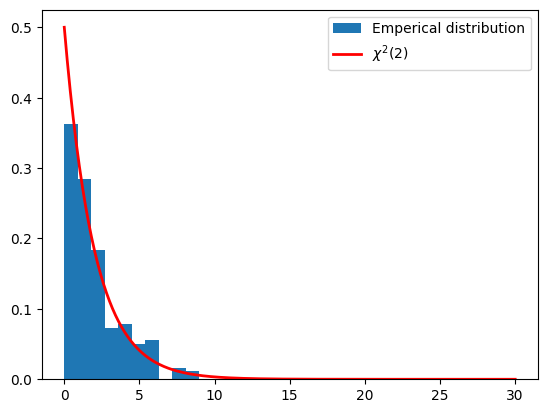

In [82]:
predictions_Sigma = model.predict(X_test_n, verbose=0)

#We know (Y1, Y2) ~ N_2(f(x), Sigma), so (Y − μ)^t Σ^(−1) (Y − μ) ∼ χ2(2).
Q = np.zeros(len(Y_test_n))

for i in range(len(Y_test_n)):
    #calculate the residuals (Y − μ)
    r = Y_test[i] - test_pred[i]

    #the covariance matrix
    Sigma = np.array([
        [predictions_Sigma[i,0], predictions_Sigma[i,1]],
        [predictions_Sigma[i,1], predictions_Sigma[i,2]]
    ])

    #calculate the inverse
    Sigma_inv = np.linalg.inv(Sigma)

    #emperical distribution, this should follow a Chi squared distribution
    Q[i] = r.T @ Sigma_inv @ r

from scipy.stats import chi2

#Testing it
alpha = 0.05
critical_value = chi2.ppf(1 - alpha, df=2)  # 95% quantile

outliers = np.sum(Q > critical_value)
total = len(Q) 
print(outliers/total) #if this value is close to 0.05, the emperical distributions
#follows the theoretical one. 

# x-grid
x = np.linspace(0, 30, 300)

plt.hist(Q, density = True, label = 'Emperical distribution')
# Chi-square PDF with df=2
plt.plot(x, chi2.pdf(x, df=2), 'r-', lw=2, label=r'$\chi^2(2)$')
plt.legend()
#plt.savefig('chi.png')
plt.show()

## Question (e)

In [50]:
Ifuture_arr = Ifuture.to_numpy().flatten()

#model for estimating mean, NOTE WE USE NORMALIZED TARGETS which we scale back in for for loop
mu_model = modelmaker(n_dim)
mu_model.fit(X_train_n, Y_train_n, verbose = 0)


#model for estimating covariance, HERE WE USE NON-NORMALIZED as in (d)
Sigma_model = modelmaker_d(n_dim)
Sigma_model.fit(X_train_n, train_targets, epochs=100, batch_size=50,verbose = 0)


In [53]:
# #NOTE THAT THIS CELL TAKES 1840 SEC TO RUN!!! (approximately half an hour)

# I_arr = I.to_numpy().flatten()

# Y_1_scenario = np.zeros((100, 200))
# Y_2_scenario = np.zeros((100, 200))

# m_scenarios = 100

# #initialize, we are estimating from time step Y[1000], so the first values are 
# X_e = np.array([
#     Y_combined[996,0], Y_combined[996,1], I_arr[996],
#     Y_combined[997,0], Y_combined[997,1], I_arr[997],
#     Y_combined[998,0], Y_combined[998,1], I_arr[998],
#     Y_combined[999,0], Y_combined[999,1], I_arr[999]
# ])


# #loop over the number of scenarios
# for j in range(m_scenarios):
#     #start with last known 
#     Lags = X_e.copy()

#     #loop over 200 time steps
#     for i in range(200):

#         X_4_stepsback_n =  (Lags - X_mean) / X_std

#         #predict mean with model from (a)
#         mu_pred_n = mu_model.predict(X_4_stepsback_n.reshape(1,-1), verbose=0)[0]
#         mu_pred   = mu_pred_n * Y_std + Y_mean
        
        
#         #predict estimated covarience with model from (d)
#         Sigma_pred = Sigma_model.predict(X_4_stepsback_n.reshape(1,-1), verbose=0)[0]
        
#         Sigma = np.array([
#             [Sigma_pred[0], Sigma_pred[1]],
#             [Sigma_pred[1], Sigma_pred[2]]
#         ])
        

#         #sample Y[i] randomly from multivariate normal distribution
#         Y_sample = np.random.multivariate_normal(mu_pred, Sigma)
        
#         #store it in scenario arrays
#         Y_1_scenario[j, i] = Y_sample[0]
#         Y_2_scenario[j, i] = Y_sample[1]

#          #update the lags
#         Lags[:-3] = Lags[3:]   # drop oldest (Y1, Y2, Ifuture)
#         Lags[-3:-1] = Y_sample   # Y1, Y2
#         Lags[-1] = Ifuture_arr[i]  # interest rate



[ 46.40143483  99.77616885   3.44290219  44.25678488 141.69423729
   3.25582384  46.88727554 162.1205398    3.33725658  48.02199221
 188.67503346   3.212367  ]
[ 0.6134189  -0.51745495  1.0979226   0.49546611 -0.01104206  0.71161032
  0.64093905  0.23529919  0.87809577  0.70340908  0.55620009  0.62021059]


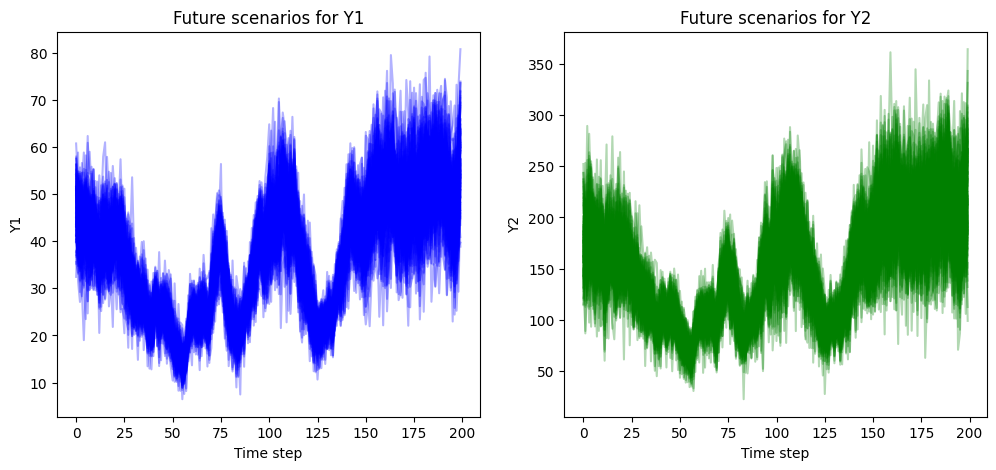

In [72]:
#plot them 
plt.figure(figsize=(12,5))

# Y1 scenarios
plt.subplot(1,2,1)
for j in range(m_scenarios):
    plt.plot(Y_1_scenario[j,:], color='blue', alpha=0.3)
plt.title("Future scenarios for Y1")
plt.xlabel("Time step")
plt.ylabel("Y1")

# Y2 scenarios
plt.subplot(1,2,2)
for j in range(m_scenarios):
    plt.plot(Y_2_scenario[j,:], color='green', alpha=0.3)
plt.title("Future scenarios for Y2")
plt.xlabel("Time step")
plt.ylabel("Y2")

plt.savefig('scenarios.png')
plt.show()

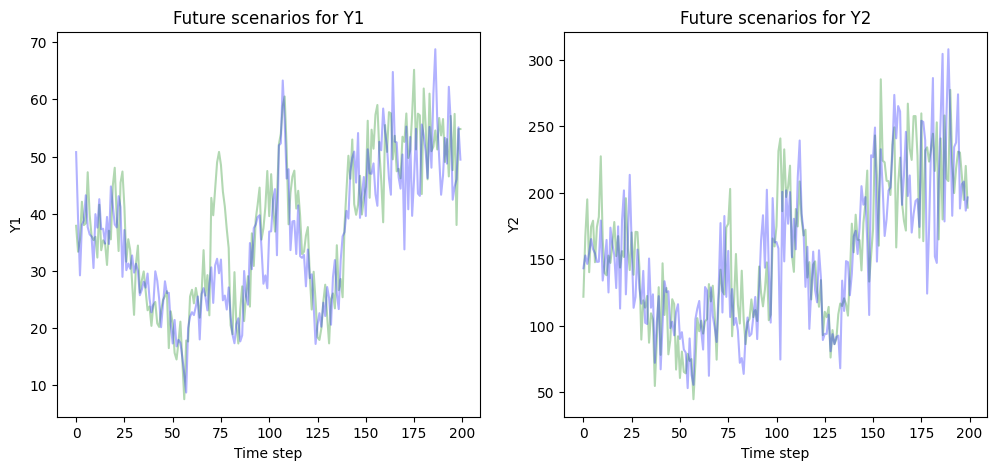

In [60]:
#Plot just two of them 

plt.figure(figsize=(12,5))

# Y1 scenarios
plt.subplot(1,2,1)
plt.plot(Y_1_scenario[0,:], color='green', alpha=0.3)
plt.plot(Y_1_scenario[50,:], color='blue', alpha=0.3)

plt.title("Future scenarios for Y1")
plt.xlabel("Time step")
plt.ylabel("Y1")

# Y2 scenarios
plt.subplot(1,2,2)
plt.plot(Y_2_scenario[0,:], color='green', alpha=0.3)
plt.plot(Y_2_scenario[50,:], color='blue', alpha=0.3)

plt.title("Future scenarios for Y2")
plt.xlabel("Time step")
plt.ylabel("Y2")


plt.show()

## Here is some extra coding that has not been 'polished.' Not relevant for report. (Left in in case author wants to review at a later time.)

## Question (d) for normalized targets $(Y_1, Y_2)$ and for model (b)

In [86]:
#For normalized Y1, Y2:

#estimate the covariance matrix
model = modelmaker(n_dim)
model.fit(X_train_n, Y_b_train_n, epochs=100, batch_size=50, verbose=0)

#the estimated mu's: We set E(Y_i) approx = Y_i = mu later
train_pred = model.predict(X_train_n)
test_pred = model.predict(X_test_n)

#residuals
Y_res_train = Y_b_train_n - train_pred
Y_res_test = Y_b_test_n - test_pred

#Cholesky entries
C_train = np.zeros((996, 3))
C_train[:,0] = np.abs(Y_res_train[:,0])  #c11
C_train[:,1] = Y_res_train[:,0]* Y_res_train[:,1]/C_train[:,0]       #c12
C_train[:,2] = Y_res_train[:,1]**2-C_train[:,1]**2    #c22_squared

C_test = np.zeros((200, 3))
C_test[:,0] = np.abs(Y_res_test[:,0])
C_test[:,1] = Y_res_test[:,0]*Y_res_test[:,1]/C_test[:,0]
C_test[:,2] = Y_res_test[:,1]**2-C_test[:,0]**2

#targets
train_targets = np.zeros((len(Y_train), 3))
train_targets[:,0] = Y_res_train[:,0]**2
train_targets[:,1] = Y_res_train[:,0] * Y_res_train[:,1]
train_targets[:,2] = Y_res_train[:,1]**2


test_targets = np.zeros((len(Y_test), 3))
test_targets[:,0] = Y_res_test[:,0]**2
test_targets[:,1] = Y_res_test[:,0] * Y_res_test[:,1]
test_targets[:,2] = Y_res_test[:,1]**2


#print(test_targets)



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [88]:
model_Sigma_n = modelmaker_d(n_dim)
model_Sigma_n.fit(X_train_n, C_train, epochs=100, batch_size=50,verbose = 0)

In [89]:
pred_Sigma_n = model_Sigma_n.predict(X_test_n)

#Cholesky decomposition
# c11 = np.abs(pred_Sigma_n[:,0])
# c21 = pred_Sigma_n[:,1]/c11
# c22_squared = pred_Sigma_n[:,2]**2 - c21**2

Q = np.zeros(len(Y_test_n))


#assemble the Covariance matrices
for i in range(len(Y_test_n)):
    c11 = pred_Sigma_n[i, 0]
    c21 = pred_Sigma_n[i, 1]
    c22_squared = pred_Sigma_n[i,2]
    Sigma_matrix = np.array([[c11**2, c11*c21],
                             [c11*c21, c21**2+c22_squared]])
    Sigma_inv = np.linalg.inv(Sigma_matrix)

    Q[i] = r.T @ Sigma_inv @ r

#We know (Y1, Y2) ~ N_2(f(x), Sigma), so (Z − μ)^t Σ^(−1) (Z − μ) ∼ χ2(2).

# for i in range(len(Y_test_n)):
#     r = Y_test_n[i] - test_pred[i]

#     Sigma = np.array([
#         [pred_Sigma_n[i,0], pred_Sigma_n[i,1]],
#         [pred_Sigma_n[i,1], pred_Sigma_n[i,2]]
#     ])

#     eps = 1e-6
#     Sigma += eps * np.eye(2)
#     Sigma_inv = np.linalg.inv(Sigma)

#     Q[i] = r.T @ Sigma_inv @ r

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [90]:
Q_mean = np.mean(Q)
Q_var  = np.var(Q)

from scipy.stats import chi2
#print(Q)
print(Q)

print("Empirical quantiles:", np.quantile(Q, [0.1, 0.5, 0.9]))
print("Chi2 quantiles:", chi2.ppf([0.1, 0.5, 0.9], df=2))

[-1.86434969e-01  1.44502026e+00 -8.44099607e+00 -1.15451238e+00
 -5.95006370e-01 -7.67854160e-02  5.43810708e-01 -1.32355652e+00
  1.71592534e-01  7.43695910e-02 -4.38415889e-01  3.68871514e-01
  8.91565329e-02 -3.70924949e-02  3.66979243e-01 -4.52298997e-01
 -1.18675021e+01  1.71703536e-01  1.76762373e-02  3.53505667e-02
  4.00437871e-02 -1.11092803e+00  2.30925024e-01  3.01222522e+00
 -1.70798005e-02 -4.82055223e-01  2.81865461e-02 -4.52759898e-01
 -1.66666515e-01 -2.25138780e+00 -3.57903381e-02 -8.37632377e-01
 -8.10085136e-02 -5.92890218e-01 -5.45341752e-01  3.55615711e-02
 -1.96236849e+02 -8.27840811e+00  4.29462578e-01  2.98644896e-02
  1.22632327e-01  4.64802058e-01 -1.44327501e+00  1.60397218e+01
 -5.89411065e-01  8.08835332e-02 -3.34265545e-02  1.04955488e+00
 -2.85375670e-01  3.33278301e-01  3.01846722e-02  2.37141938e-02
 -7.99172541e-02  2.27919672e-02  5.24353053e-01 -2.62758601e+00
 -3.61117340e-01  2.79392426e-02  2.25328757e-02  6.99068724e-02
 -6.48279160e-01  7.59594

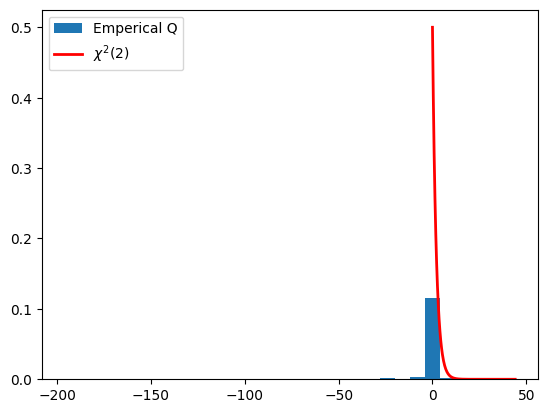

In [91]:
# x-grid
x = np.linspace(0, np.max(Q), 300)

# Chi-square PDF with df=2


plt.hist(Q, bins = 30, density = True, label = 'Emperical Q')
plt.plot(x, chi2.pdf(x, df=2), 'r-', lw=2, label=r'$\chi^2(2)$')
plt.legend()
plt.show()

## For model (a)

In [96]:
#For normalized Y1, Y2:

#estimate the covariance matrix
model = modelmaker(n_dim)
model.fit(X_train_n, Y_train_n, epochs=100, batch_size=50, verbose=0)

#the estimated mu's: We set E(Y_i) approx = Y_i = mu later
train_pred = model.predict(X_train_n)
test_pred = model.predict(X_test_n)

#residuals
Y_res_train = Y_train_n - train_pred
Y_res_test = Y_test_n - test_pred

#targets
train_targets = np.zeros((len(Y_train), 3))
train_targets[:,0] = Y_res_train[:,0]**2
train_targets[:,1] = Y_res_train[:,0] * Y_res_train[:,1]
train_targets[:,2] = Y_res_train[:,1]**2


test_targets = np.zeros((len(Y_test), 3))
test_targets[:,0] = Y_res_test[:,0]**2
test_targets[:,1] = Y_res_test[:,0] * Y_res_test[:,1]
test_targets[:,2] = Y_res_test[:,1]**2


#print(test_targets)



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [97]:
model_Sigma_n = modelmaker_d(n_dim)
model_Sigma_n.fit(X_train_n, train_targets, epochs=100, batch_size=50,verbose = 0)

In [102]:
pred_Sigma_n = model_Sigma_n.predict(X_test_n)
print(pred_Sigma_n[:,0])
#evaluate on the test set
MSE_Y1_n_d = np.mean((pred_Sigma_n[:,0] - test_targets[:,0])**2)
MSE_Y2_n_d = np.mean((pred_Sigma_n[:,1] - test_targets[:,1])**2)
print(round(MSE_Y1_n_d, 7), round(MSE_Y2_n_d, 7))

#assemble the Covariance matrix
Sigma_matrix = np.zeros((2,2))

means = np.mean(pred_Sigma_n, axis = 0)
Sigma_matrix[0,0] = means[0]
Sigma_matrix[0,1] = means[1]
Sigma_matrix[1,0] = means[1]
Sigma_matrix[1,1] = means[2]


#We know (Y1, Y2) ~ N_2(f(x), Sigma), so (Z − μ)^t Σ^(−1) (Z − μ) ∼ χ2(2).
Q = np.zeros(len(Y_test_n))

for i in range(len(Y_test_n)):
    r = Y_test_n[i] - test_pred[i]

    Sigma = np.array([
        [pred_Sigma_n[i,0], pred_Sigma_n[i,1]],
        [pred_Sigma_n[i,1], pred_Sigma_n[i,2]]
    ])

    #this is to ensure that Sigma is symmetric positive definite
    eps = 1e-6
    Sigma += eps * np.eye(2)
    Sigma_inv = np.linalg.inv(Sigma)

    Q[i] = r.T @ Sigma_inv @ r

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[ 0.00257908  0.01842961  0.01361946  0.02118074  0.0044386   0.02556338
  0.01226601  0.00049846  0.01341276  0.00610802  0.00757122  0.02618086
 -0.00405867  0.00735085  0.0082391   0.00353512  0.00944213  0.00645946
  0.01223556  0.00914058  0.01065113  0.00983055  0.00779047  0.00970379
  0.01340223  0.00493959  0.00679674  0.00826928 -0.00178125  0.00352435
  0.02124382  0.01398613  0.02434068  0.00452153 -0.00583778  0.00891756
  0.03594727  0.00716188  0.02246786  0.00761542  0.0157696  -0.00091841
  0.01377765  0.0291144   0.00743691  0.02702722  0.01075889  0.00519256
 -0.00316641  0.02371698  0.00587589  0.02149474  0.01174818  0.01290407
  0.00590568  0.00671222  0.00633422  0.01028036  0.01544964  0.01254853
  0.00759161  0.01220862  0.00569999  0.01039363  0.00516043  0.01028696
  0.00072007  0.04845459  0.00657941  0.0046735   0.0298826   0.01429532
  0.00213932  0.01062674  0.01103471  0.01337527  0.01340113  0.04664805
  0.00769541 

[-2.56201246e+01 -6.75917838e-01 -7.62310980e-01 -1.53487064e+01
 -4.74290356e+00 -1.06793293e+00 -8.64631552e+00 -1.23787589e-01
 -7.30829235e+00 -3.84886801e+00 -4.62560588e-01 -2.41120610e+01
 -4.62143579e+00 -1.03192628e+01 -1.25002361e-01 -6.72297065e+01
 -7.76509558e+01 -3.48777223e+01 -1.28107993e+01 -1.49061610e-01
 -7.63300740e+00 -2.87615937e+00 -2.50111886e+01 -8.66590543e+01
 -1.05329011e+01 -1.47025091e+00 -4.73315558e+02 -1.08706409e+00
 -1.91894810e+00]
Empirical quantiles: [-1.51512062  1.8500705   9.17900261]
Chi2 quantiles: [0.21072103 1.38629436 4.60517019]


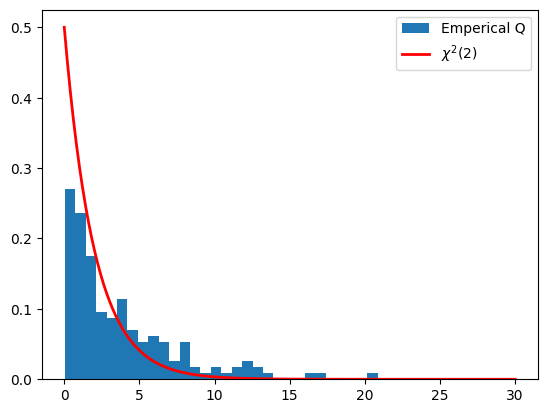

In [99]:
Q_mean = np.mean(Q)
Q_var  = np.var(Q)

from scipy.stats import chi2

print(Q[Q<0])

print("Empirical quantiles:", np.quantile(Q, [0.1, 0.5, 0.9]))
print("Chi2 quantiles:", chi2.ppf([0.1, 0.5, 0.9], df=2))

# x-grid
x = np.linspace(0, 30, 300)

# Chi-square PDF with df=2
QQ = Q[Q>0]

plt.hist(QQ[QQ<30], bins = 30, density = True, label = 'Emperical Q')
plt.plot(x, chi2.pdf(x, df=2), 'r-', lw=2, label=r'$\chi^2(2)$')
plt.legend()
plt.show()

## Question (d) different approach


In [ ]:
#We want our Cov matrix to be PSD, so we use log variances



## Question (e), for normalized targets Y

In [42]:
Ifuture_arr = Ifuture.to_numpy()

#model for estimating mean
mu_model = modelmaker(n_dim)
mu_model.fit(X_train_n, Y_train_n, verbose = 0)
pred_mu = mu_model.predict(X_test_n)

#model for estimating covariance
Sigma_model = modelmaker_d(n_dim)
Sigma_model.fit(X_train_n, train_targets, epochs=100, batch_size=50,verbose = 0)
pred_Sigma = Sigma_model.predict(X_test_n)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [46]:

print(len(Y_test_n))

Y_1_scenario = np.zeros((100, 200))
Y_2_scenario = np.zeros((100, 200))

scenarios = 2

for j in range(scenarios):

    for i in range(len(Y_test_n)):
    
        Sigma = np.array([
            [pred_Sigma_n[i,0], pred_Sigma_n[i,1]],
            [pred_Sigma_n[i,1], pred_Sigma_n[i,2]]
        ])
            
        Y_1_scenario[j, i] = np.random.multivariate_normal(pred_mu[i], Sigma)[0]
        Y_2_scenario[j, i] = np.random.multivariate_normal(pred_mu[i], Sigma)[1]


200


/tmp/ipykernel_747758/3988590498.py:17: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Y_1_scenario[j, i] = np.random.multivariate_normal(pred_mu[i], Sigma)[0]
/tmp/ipykernel_747758/3988590498.py:18: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  Y_2_scenario[j, i] = np.random.multivariate_normal(pred_mu[i], Sigma)[1]


[[0.30781801 0.29256524 0.58340676 ... 0.11332913 0.33472938 0.23622921]
 [0.31053019 0.26935032 0.36566882 ... 0.34962821 0.12687012 0.19124834]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
